In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd

import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size
from numpyro.infer import MCMC, NUTS, Predictive

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

/home/alexander/anaconda3/envs/bayes/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/home/alexander/Data/pokemon/psa_experiment.csv')
# Head not shown to hide which cards were included.

In [3]:
df = df[['Card', 'total_regrades', 'total_changes']]
df.columns = ['card', 'n', 'events']
df['events'] = df['events'].astype('int')
df['n'] = df['n'].astype('int')

In [4]:
# Head not shown to hide which cards were included.

In [5]:
df['card'] = pd.factorize(df['card'])[0]

In [6]:
df.events.sum() / df.n.sum()

0.3492063492063492

In [7]:
df.head()

,card,n,events
0,0,2,0
1,1,2,0
2,2,2,0
3,3,2,0
4,4,2,1


In [8]:
prior_mean = dist.Beta(3, 6)
prior_concentration = dist.Normal(12, 2)

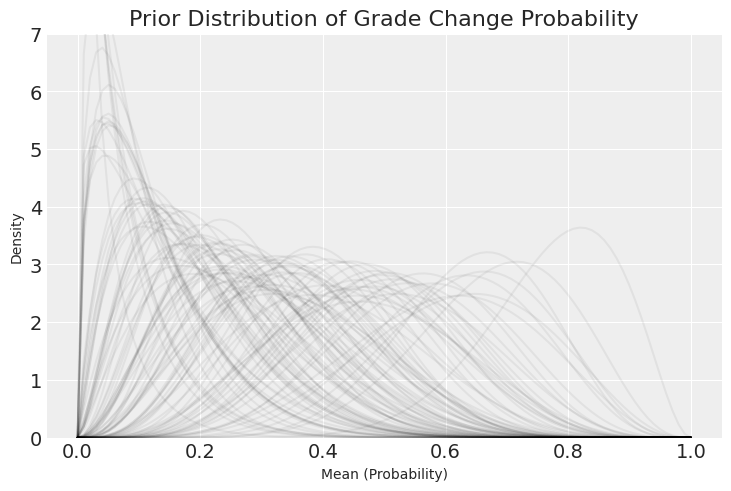

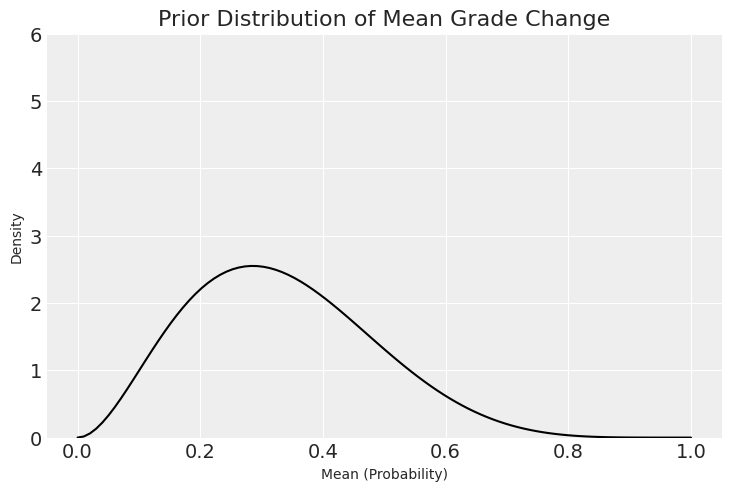

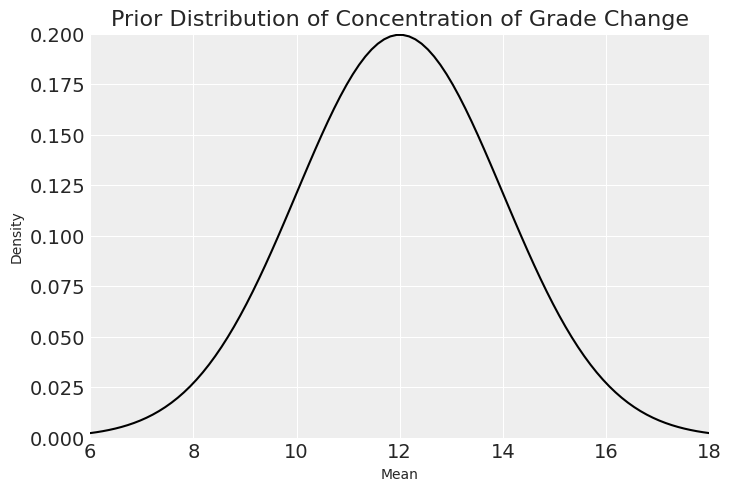

In [9]:
# prior simulation
with numpyro.handlers.seed(rng_seed=999):
    N = 100  # Beta distributions
    mean = numpyro.sample("mean", prior_mean.expand([N]))
    concentration = numpyro.sample("concentration", prior_concentration.expand([N]))

plt.subplot(
    xlim=(-0.05, 1.05),
    ylim=(0, 7),
    xlabel="Mean (Probability)",
    ylabel="Density",
)
x = jnp.linspace(0, 1, 100)
plt.title("Prior Distribution of Grade Change Probability")
for i in range(N):
    plt.plot(
        x,
        jnp.exp(dist.BetaProportion(mean[i], concentration[i]).log_prob(x)),
        "k",
        alpha=0.05,
    )
plt.savefig("./prior_distribution_grade_change.png")
plt.show()

plt.subplot(
xlim=(-0.05, 1.05),
ylim=(0, 6),
xlabel="Mean (Probability)",
ylabel="Density",
)

plt.title("Prior Distribution of Mean Grade Change")
plt.plot(
    x,
    jnp.exp(prior_mean.log_prob(x)),
    "k",
    alpha=1,
)
plt.savefig("./prior_mean_distribution_grade_change.png")
plt.show()

plt.subplot(
xlim=(6, 18),
ylim=(0, 0.2),
xlabel="Mean",
ylabel="Density",
)
x2 = jnp.linspace(6, 18, 100)
plt.title("Prior Distribution of Concentration of Grade Change")
plt.plot(
    x2,
    jnp.exp(prior_concentration.log_prob(x2)),
    "k",
    alpha=1,
)
plt.savefig("./prior_concentration_distribution_grade_change.png")
plt.show()

In [10]:
dat = dict(card=df.card.values, n=df.n.values, events=df.events.values)

def model(card, n, events):
    mean = numpyro.sample('mean', prior_mean)
    concentration = numpyro.sample('concentration', prior_concentration)
    p_card = numpyro.sample('p_card', dist.BetaProportion(mean, concentration), sample_shape=card.shape)
    p = p_card[card]
    numpyro.sample('grade_change', dist.Binomial(n, probs=p), obs=events)
    
m = MCMC(NUTS(model), num_warmup=1000, num_samples=2000, num_chains=4)
m.run(random.PRNGKey(0), **dat)

Compiling.. :   0%|                                    | 0/3000 [00:00<?, ?it/s]

  0%|                                                  | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                    | 0/3000 [00:00<?, ?it/s]


  0%|                                                  | 0/3000 [00:00<?, ?it/s]


Compiling.. :   0%|                                    | 0/3000 [00:00<?, ?it/s]

Running chain 0:   0%|                                 | 0/3000 [00:03<?, ?it/s]


Running chain 3: 100%|█████████████████████| 3000/3000 [00:03<00:00, 809.44it/s]


In [11]:
m.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  concentration     11.90      1.97     11.92      8.64     15.11   5543.73      1.00
           mean      0.35      0.06      0.34      0.25      0.44   2587.20      1.00
      p_card[0]      0.29      0.13      0.28      0.08      0.50   7523.48      1.00
      p_card[1]      0.29      0.13      0.28      0.07      0.49   7479.94      1.00
      p_card[2]      0.30      0.13      0.29      0.09      0.50   7643.40      1.00
      p_card[3]      0.29      0.13      0.28      0.08      0.50   8096.84      1.00
      p_card[4]      0.37      0.14      0.36      0.14      0.59   8263.64      1.00
      p_card[5]      0.37      0.14      0.36      0.14      0.58   8668.61      1.00
      p_card[6]      0.29      0.13      0.28      0.08      0.49   7354.15      1.00
      p_card[7]      0.30      0.13      0.29      0.10      0.50   8049.30      1.00
      p_card[8]      0.30      0.13      0.28      0.

In [12]:
posterior = m.get_samples()

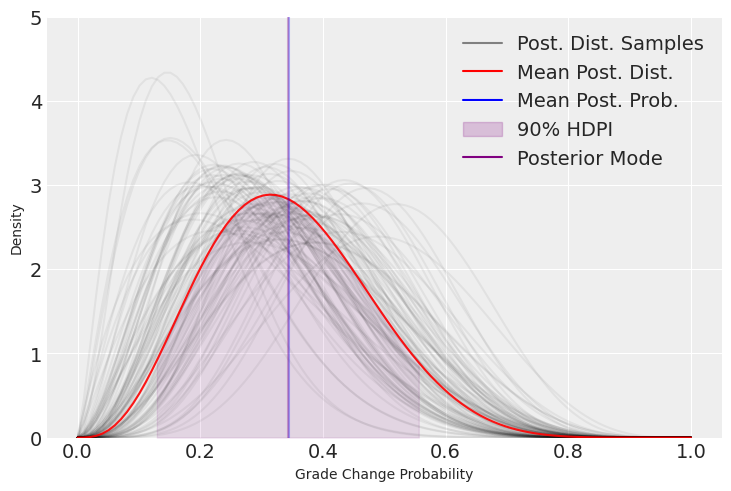

In [13]:
### This plot is not very informative, since it shows samples from the overall PSA grade change distribution. We care mainly about mean and concentration.

# Create the subplot on which the graphics will be made
plt.subplot(xlim=(-0.05, 1.05), ylim=(0, 5), xlabel="Grade Change Probability", ylabel="Density")

# Plot several random sample distributions using the posterior alpha and beta draws
sample_means = []
for i in range(100):
    x = jnp.linspace(0, 1, 100)
    plt.plot(
        x,
        jnp.exp(dist.BetaProportion(posterior["mean"][i], posterior["concentration"][i]).log_prob(x)),
        "k",
        alpha=0.05,
    )
    
    # Also store the mean of the sampled distribution
    mean = dist.BetaProportion(posterior["mean"][i], posterior["concentration"][i]).sample(key=random.PRNGKey(1), sample_shape=(1000,)).mean().item()
    sample_means.append(mean)

# Plot the mean posterior distribution, and also store a sample from it
plt.plot(x, jnp.exp(dist.BetaProportion(posterior["mean"].mean(), posterior["concentration"].mean()).log_prob(x)), color='red', alpha=0.9, label="Mean Posterior Distribution")
mean_posterior_sample = dist.BetaProportion(posterior["mean"].mean(), posterior["concentration"].mean()).sample(key=random.PRNGKey(1), sample_shape=(20000,))
mean_posterior_sample = jnp.array(mean_posterior_sample)

# Calculate the HDPI of the mean posterior distribution
hdi = numpyro.diagnostics.hpdi(mean_posterior_sample, 0.90)

# Calculate the mode using the HDPI
premode = numpyro.diagnostics.hpdi(mean_posterior_sample, 0.1)
mode = (hdi[0] + hdi[1]) / 2

# Plot the mean of the mean posterior distribution
plt.axvline(x=dist.BetaProportion(posterior["mean"].mean(), posterior["concentration"].mean()).sample(key=random.PRNGKey(1), sample_shape=(10000,)).mean(),
            color='blue',
            alpha=0.3,
            label="Mean Posterior Prob.")

# Plot the posterior mode
plt.axvline(x=mode,
            color='purple',
            alpha=0.3,
            label="Posterior Mode.")

# Shade the area under the mean posterior distribution within the HPDI
hdpi_seq = jnp.linspace(hdi[0], hdi[1], 100)
dist_bound = jnp.array([jnp.exp(dist.BetaProportion(posterior["mean"].mean(), posterior["concentration"].mean()).log_prob(prob)) for prob in hdpi_seq])
plt.fill_between(hdpi_seq, 0, dist_bound,
                 color='purple', alpha=0.10)

# Make markers for legend
grey_sample_marker = mlines.Line2D([], [], color='gray',
                          markersize=8, label="Post. Dist. Samples")
red_dist_marker = mlines.Line2D([], [], color='red',
                          markersize=8, label="Mean Post. Dist.")
blue_mean_marker = mlines.Line2D([], [], color='blue',
                          markersize=8, label="Mean Post. Prob.")
purple_mode_marker = mlines.Line2D([], [], color='purple',
                          markersize=8, label="Posterior Mode")
hdpi_legend = mpatches.Patch([], [], color='purple', label="90% HDPI", alpha=0.20)

# Plot legend
plt.legend(handles=[grey_sample_marker, red_dist_marker, blue_mean_marker, hdpi_legend, purple_mode_marker])

plt.savefig("./posterior_distributions.png")
plt.show()

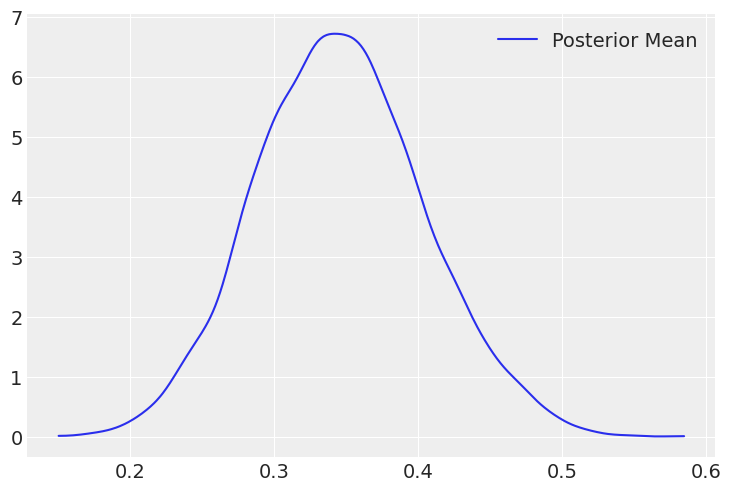

In [14]:
az.plot_kde(posterior['mean'], label="Posterior Mean")
plt.show()

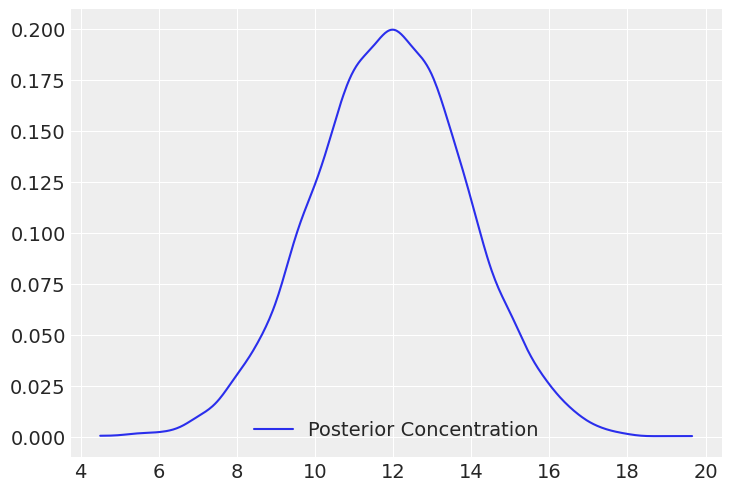

In [15]:
az.plot_kde(posterior['concentration'], label="Posterior Concentration")
plt.show()

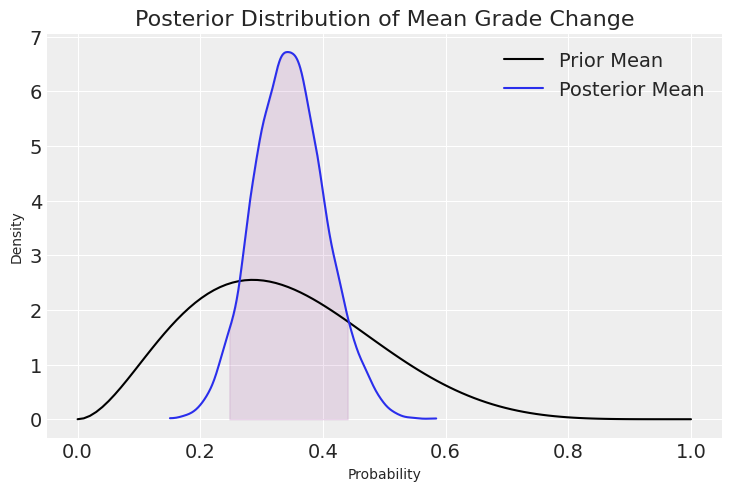

In [16]:
plt.subplot(
xlim=(-0.05, 1.05),
ylim=(0, 5),
xlabel="Probability",
ylabel="Density",
)

plt.title("Posterior Distribution of Mean Grade Change")
plt.plot(
    x,
    jnp.exp(prior_mean.log_prob(x)),
    "k",
    alpha=1,
    label="Prior Mean"
)
# Calculate the HDPI of the mean posterior distribution
hdi = numpyro.diagnostics.hpdi(posterior['mean'], 0.90)

# Shade the area under the posterior mean distribution within the HPDI
az.plot_kde(posterior['mean'], label="Posterior Mean")
kde = az.kde(posterior['mean'])
kde_bounds = kde[0][(kde[0] >= hdi[0]) & (kde[0] <= hdi[1])]
kde_values = kde[1][(kde[0] >= hdi[0]) & (kde[0] <= hdi[1])]
plt.fill_between(kde_bounds, 0, kde_values, color='purple', alpha=0.1)
plt.savefig("./prior_vs_posterior_mean.png")
plt.show()

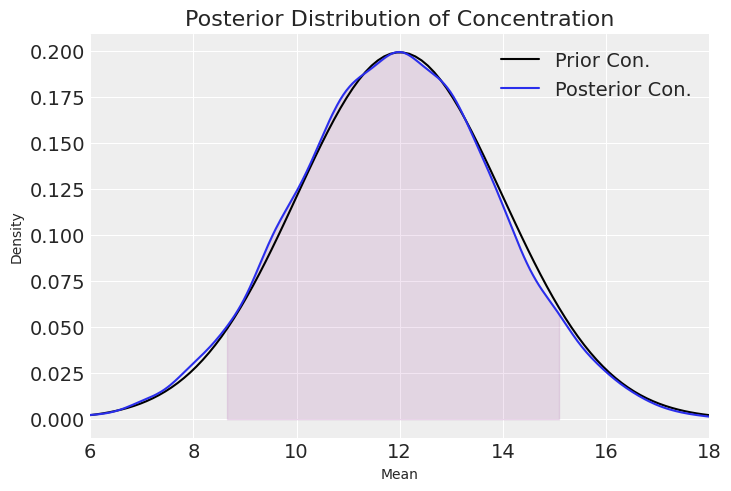

In [17]:
plt.subplot(
xlim=(6, 18),
ylim=(0, 0.2),
xlabel="Mean",
ylabel="Density",
)

plt.title("Posterior Distribution of Concentration")
plt.plot(
    x2,
    jnp.exp(prior_concentration.log_prob(x2)),
    "k",
    alpha=1,
    label="Prior Con."
)
# Calculate the HDPI of the mean posterior distribution
hdi = numpyro.diagnostics.hpdi(posterior['concentration'], 0.90)

# Shade the area under the posterior mean distribution within the HPDI
az.plot_kde(posterior['concentration'], label="Posterior Con.")
kde = az.kde(posterior['concentration'])
kde_bounds = kde[0][(kde[0] >= hdi[0]) & (kde[0] <= hdi[1])]
kde_values = kde[1][(kde[0] >= hdi[0]) & (kde[0] <= hdi[1])]
plt.fill_between(kde_bounds, 0, kde_values, color='purple', alpha=0.1)
plt.show()